# Train a worm segmentation network

Training data is hand-drawn masks of worm in each frame. it gets augmented through rotations

`conda activate segment-torch` or `segment_torch29`

See `eval_torch.py`

Torch: 2.8.0+cu129
Torch CUDA: 12.9
Device: NVIDIA GeForce RTX 5080
CUDA available: True


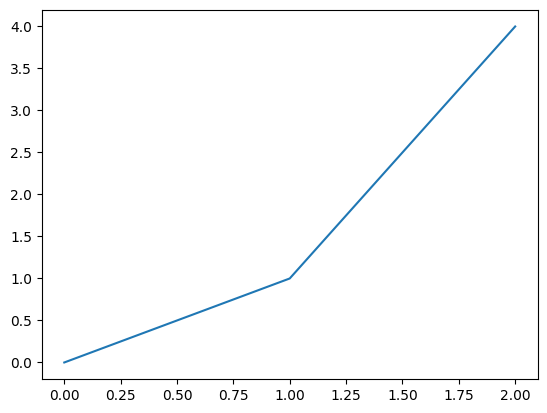

In [1]:
import torch, torchvision, matplotlib
print("Torch:", torch.__version__)
print("Torch CUDA:", torch.version.cuda)
print("Device:", torch.cuda.get_device_name(0))
print("CUDA available:", torch.cuda.is_available())

import matplotlib.pyplot as plt
plt.plot([0,1,2],[0,1,4])
plt.show()


In [2]:
import torch
x = torch.randn(1000,1000, device='cuda')
y = x @ x
print(y.device, y.mean())


cuda:0 tensor(0.0414, device='cuda:0')


Torch: 2.8.0+cu129
CUDA available: True


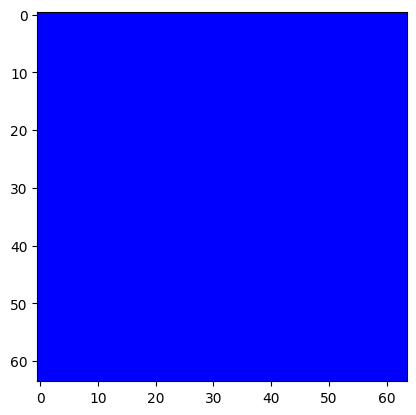

In [3]:
from PIL import Image
import torch
import matplotlib.pyplot as plt

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

img = Image.new("RGB", (64, 64), "blue")
plt.imshow(img)
plt.show()


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

import os
import glob
import random
import math
import tifffile
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import segmentation_models_pytorch as smp
from scipy.stats import zscore


In [5]:
# -----------------------------
# Config
# -----------------------------
TRAIN_GLOB = r'training/*_label.tif'
WEIGHTS_PATH = 'deeplab_v3p_resnet50_channels1.pth'  # torch checkpoint
LEARNING_RATE = 5e-5
BATCH_SIZE = 4
# EPOCHS = 20 # Epoch 020 | val_loss: 0.020820
EPOCHS = 100 
VAL_SPLIT = 0.1
RNG_SEED = 42
NUM_WORKERS = 0  # Windows-safe default
LOG_DIR = r'runs/seg_logs'
# ----------------
# Early stopping
# ----------------
EARLY_PATIENCE = 8
early_counter = 0
# ----------------
# Learning rate scheduler
# ----------------
lrfactor=0.5,
lrpatience=3,
lrthreshold=1e-4,


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {DEVICE}')

Using device: cuda


In [6]:
# -----------------------------
# Helpers for I/O to match your original data layout
# -----------------------------
def label_to_class_indices(label_path: str) -> np.ndarray:
    """
    read the TIFF and convert to class indices [0, 1].
    """
    lab = tifffile.imread(label_path)
    # lab is expected boolean or 0/1 mask for foreground
    # ensure boolean
    lab_bool = lab.astype(bool)
    # class index: 1 where mask True, else 0
    return lab_bool.astype(np.int64)

def image_to_3ch_zscore(image_path: str) -> np.ndarray:
    """
    Read the RFP TIFF (single channel), z-score across all pixels,
    and replicate to 3 channels (H, W, 3)
    """
    rfp = tifffile.imread(image_path).astype(np.float32)
    rfp_z = zscore(rfp, axis=None)
    # handle any potential NaNs (e.g., constant image)
    if np.isnan(rfp_z).any():
        rfp_z = np.nan_to_num(rfp_z, nan=0.0)
    h, w = rfp.shape[-2], rfp.shape[-1] if rfp.ndim == 3 else rfp.shape[1]
    # Support (H, W) or (Z, H, W) by max projecting
    if rfp.ndim == 3:
        rfp_z = rfp_z.max(axis=0)
    image = np.stack([rfp_z, rfp_z, rfp_z], axis=-1).astype(np.float32)
    return image

# -----------------------------
# Dataset
# -----------------------------
class SegDataset(Dataset):
    def __init__(self, image_paths, label_paths, augment=True, make_rgb=True):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.augment = augment
        self.make_rgb = make_rgb

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        lab_path = self.label_paths[idx]

        img = image_to_3ch_zscore(img_path)          # (H, W, 3), float32
        if not self.make_rgb:
            img = img[:,:,0]
        lab = label_to_class_indices(lab_path)       # (H, W), int64 in {0,1}

        # Random flips
        if self.augment:
            if random.randint(0, 1):
                img = img[::-1, :, :]
                lab = lab[::-1, :]
            if random.randint(0, 1):
                img = img[:, ::-1, :]
                lab = lab[:, ::-1]

        # To torch tensors: CHW for image, HW for label
        img_t = torch.from_numpy(img.copy()).permute(2, 0, 1).contiguous() # (3, H, W)
        lab_t = torch.from_numpy(lab.copy())      # (H, W), long class indices
        return img_t, lab_t

In [7]:
# -----------------------------
# Get data
# -----------------------------
label_paths = sorted(glob.glob(TRAIN_GLOB))
if len(label_paths) == 0:
    raise FileNotFoundError(f'No label files found with pattern: {TRAIN_GLOB}')
image_paths = [p[:-10] + '.tif' for p in label_paths]  # strip "_label.tif" -> ".tif"

# Quick shape sanity check on one sample
_debug_img = image_to_3ch_zscore(image_paths[0])
_debug_lab = label_to_class_indices(label_paths[0])
print('Sample image shape:', _debug_img.shape, 'label shape:', _debug_lab.shape)

Sample image shape: (512, 512, 3) label shape: (512, 512)


In [8]:
_debug_img.shape

(512, 512, 3)

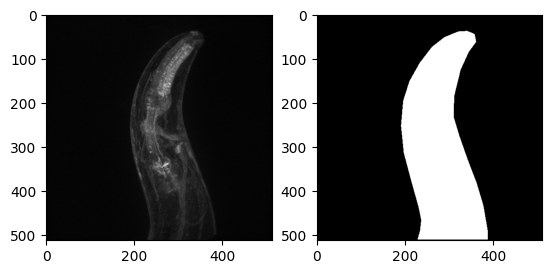

In [9]:
%matplotlib inline
plt.figure()
plt.subplot(1,2,1)
plt.imshow(_debug_img[:,:,0],cmap='gray')
plt.subplot(1,2,2)
plt.imshow(_debug_lab[:,:],cmap='gray')
plt.show()

In [10]:
# -----------------------------
# Dataset & Dataloaders
# -----------------------------
random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)
np.random.seed(RNG_SEED)

dataset = SegDataset(image_paths, label_paths, augment=True)

val_len = max(1, int(len(dataset) * VAL_SPLIT))
train_len = len(dataset) - val_len
train_ds, val_ds = random_split(dataset, [train_len, val_len],
                                generator=torch.Generator().manual_seed(RNG_SEED))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)


In [11]:
# -----------------------------
# Model (DeepLabV3+ ResNet-50)
# -----------------------------
model = smp.DeepLabV3Plus(
    encoder_name='resnet50',       # backbone
    encoder_weights='imagenet',    # start from ImageNet weights
    in_channels=3,
    classes=2                      # background, foreground
).to(DEVICE)

# Loss & Optimizer
# We use CrossEntropyLoss on class indices (more stable than BCE on one-hot).
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ------------------------------------------------
# Add learning-rate scheduler (ReduceLROnPlateau)
# ------------------------------------------------
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    threshold=1e-4,
    # verbose=True
)

In [12]:
# Try to resume if a weights file exists
if os.path.isfile(WEIGHTS_PATH):
    print(f'Loading existing weights: {WEIGHTS_PATH}')
    ckpt = torch.load(WEIGHTS_PATH, map_location=DEVICE)
    model.load_state_dict(ckpt['model'])
    optimizer.load_state_dict(ckpt.get('optimizer', optimizer.state_dict()))

# -----------------------------
# Training loop with TensorBoard
# -----------------------------
writer = SummaryWriter(LOG_DIR)

# ----------------
# Early stopping
# ----------------
EARLY_PATIENCE = 8
early_counter = 0

def evaluate(loader):
    model.eval()
    total_loss = 0.0
    n = 0
    with torch.no_grad():
        for imgs, labs in loader:
            imgs = imgs.to(DEVICE, non_blocking=True)
            labs = labs.to(DEVICE, non_blocking=True)
            logits = model(imgs)
            loss = criterion(logits, labs)
            total_loss += float(loss.item()) * imgs.size(0)
            n += imgs.size(0)
    return total_loss / max(1, n)

best_val = math.inf
global_step = 0

try:
    for epoch in tqdm(range(1, EPOCHS + 1)):
        model.train()
        for imgs, labs in train_loader:
            imgs = imgs.to(DEVICE, non_blocking=True)
            labs = labs.to(DEVICE, non_blocking=True)
            
            if imgs.shape[0] == 1:
                continue

            optimizer.zero_grad(set_to_none=True)
            logits = model(imgs)
            loss = criterion(logits, labs)
            loss.backward()
            optimizer.step()

            writer.add_scalar('train/loss', loss.item(), global_step)
            global_step += 1

        val_loss = evaluate(val_loader)
        writer.add_scalar('val/loss', val_loss, epoch)
        print(f'Epoch {epoch:03d} | val_loss: {val_loss:.6f}')

        # Step LR scheduler using validation loss
        scheduler.step(val_loss)

        # save best
        if val_loss < best_val - 1e-7:
            best_val = val_loss
            early_counter = 0
            torch.save({
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch': epoch,
                'val_loss': val_loss,
            }, WEIGHTS_PATH)
            print(f'  -> Saved best to {WEIGHTS_PATH}')
        else:
            early_counter += 1
            print(f'  -> No improvement ({early_counter}/{EARLY_PATIENCE})')

            if early_counter >= EARLY_PATIENCE:
                print('Early stopping triggered')
                break

except KeyboardInterrupt:
    print('Training interrupted')


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 001 | val_loss: 0.222991


  1%|          | 1/100 [00:07<12:50,  7.78s/it]

  -> Saved best to deeplab_v3p_resnet50_channels1.pth
Epoch 002 | val_loss: 0.090489


  2%|▏         | 2/100 [00:12<09:40,  5.92s/it]

  -> Saved best to deeplab_v3p_resnet50_channels1.pth
Epoch 003 | val_loss: 0.065719


  3%|▎         | 3/100 [00:16<08:24,  5.20s/it]

  -> Saved best to deeplab_v3p_resnet50_channels1.pth
Epoch 004 | val_loss: 0.050754


  4%|▍         | 4/100 [00:21<07:44,  4.84s/it]

  -> Saved best to deeplab_v3p_resnet50_channels1.pth
Epoch 005 | val_loss: 0.045655


  5%|▌         | 5/100 [00:25<07:22,  4.66s/it]

  -> Saved best to deeplab_v3p_resnet50_channels1.pth
Epoch 006 | val_loss: 0.039167


  6%|▌         | 6/100 [00:29<07:05,  4.53s/it]

  -> Saved best to deeplab_v3p_resnet50_channels1.pth
Epoch 007 | val_loss: 0.037968


  7%|▋         | 7/100 [00:33<06:52,  4.44s/it]

  -> Saved best to deeplab_v3p_resnet50_channels1.pth
Epoch 008 | val_loss: 0.033848


  8%|▊         | 8/100 [00:38<06:41,  4.37s/it]

  -> Saved best to deeplab_v3p_resnet50_channels1.pth
Epoch 009 | val_loss: 0.029240


  9%|▉         | 9/100 [00:42<06:35,  4.35s/it]

  -> Saved best to deeplab_v3p_resnet50_channels1.pth
Epoch 010 | val_loss: 0.027861


 10%|█         | 10/100 [00:46<06:32,  4.36s/it]

  -> Saved best to deeplab_v3p_resnet50_channels1.pth
Epoch 011 | val_loss: 0.025347


 11%|█         | 11/100 [00:51<06:29,  4.37s/it]

  -> Saved best to deeplab_v3p_resnet50_channels1.pth
Epoch 012 | val_loss: 0.024204


 12%|█▏        | 12/100 [00:55<06:27,  4.40s/it]

  -> Saved best to deeplab_v3p_resnet50_channels1.pth
Epoch 013 | val_loss: 0.023686


 13%|█▎        | 13/100 [00:59<06:20,  4.37s/it]

  -> Saved best to deeplab_v3p_resnet50_channels1.pth
Epoch 014 | val_loss: 0.022314


 14%|█▍        | 14/100 [01:04<06:14,  4.35s/it]

  -> Saved best to deeplab_v3p_resnet50_channels1.pth


 15%|█▌        | 15/100 [01:08<06:01,  4.25s/it]

Epoch 015 | val_loss: 0.023812
  -> No improvement (1/8)


 16%|█▌        | 16/100 [01:12<05:53,  4.20s/it]

Epoch 016 | val_loss: 0.031942
  -> No improvement (2/8)
Epoch 017 | val_loss: 0.021342


 17%|█▋        | 17/100 [01:16<05:57,  4.31s/it]

  -> Saved best to deeplab_v3p_resnet50_channels1.pth
Epoch 018 | val_loss: 0.020532


 18%|█▊        | 18/100 [01:21<06:00,  4.39s/it]

  -> Saved best to deeplab_v3p_resnet50_channels1.pth
Epoch 019 | val_loss: 0.018801


 19%|█▉        | 19/100 [01:25<05:52,  4.36s/it]

  -> Saved best to deeplab_v3p_resnet50_channels1.pth


 20%|██        | 20/100 [01:29<05:40,  4.26s/it]

Epoch 020 | val_loss: 0.019720
  -> No improvement (1/8)
Epoch 021 | val_loss: 0.017871


 21%|██        | 21/100 [01:34<05:37,  4.27s/it]

  -> Saved best to deeplab_v3p_resnet50_channels1.pth


 22%|██▏       | 22/100 [01:38<05:27,  4.19s/it]

Epoch 022 | val_loss: 0.018743
  -> No improvement (1/8)


 23%|██▎       | 23/100 [01:42<05:18,  4.14s/it]

Epoch 023 | val_loss: 0.018002
  -> No improvement (2/8)


 24%|██▍       | 24/100 [01:46<05:12,  4.11s/it]

Epoch 024 | val_loss: 0.023238
  -> No improvement (3/8)


 25%|██▌       | 25/100 [01:50<05:07,  4.10s/it]

Epoch 025 | val_loss: 0.020469
  -> No improvement (4/8)
Epoch 026 | val_loss: 0.016508


 26%|██▌       | 26/100 [01:54<05:09,  4.18s/it]

  -> Saved best to deeplab_v3p_resnet50_channels1.pth


 27%|██▋       | 27/100 [01:58<05:02,  4.15s/it]

Epoch 027 | val_loss: 0.017363
  -> No improvement (1/8)
Epoch 028 | val_loss: 0.016128


 28%|██▊       | 28/100 [02:03<05:03,  4.21s/it]

  -> Saved best to deeplab_v3p_resnet50_channels1.pth


 29%|██▉       | 29/100 [02:07<04:55,  4.17s/it]

Epoch 029 | val_loss: 0.017247
  -> No improvement (1/8)


 30%|███       | 30/100 [02:11<04:49,  4.14s/it]

Epoch 030 | val_loss: 0.016348
  -> No improvement (2/8)


 31%|███       | 31/100 [02:15<04:45,  4.14s/it]

Epoch 031 | val_loss: 0.016568
  -> No improvement (3/8)
Epoch 032 | val_loss: 0.015723


 32%|███▏      | 32/100 [02:19<04:47,  4.22s/it]

  -> Saved best to deeplab_v3p_resnet50_channels1.pth


 33%|███▎      | 33/100 [02:23<04:38,  4.16s/it]

Epoch 033 | val_loss: 0.016171
  -> No improvement (1/8)


 34%|███▍      | 34/100 [02:27<04:33,  4.14s/it]

Epoch 034 | val_loss: 0.016373
  -> No improvement (2/8)


 35%|███▌      | 35/100 [02:31<04:27,  4.12s/it]

Epoch 035 | val_loss: 0.015763
  -> No improvement (3/8)


 36%|███▌      | 36/100 [02:36<04:23,  4.11s/it]

Epoch 036 | val_loss: 0.016364
  -> No improvement (4/8)


 37%|███▋      | 37/100 [02:40<04:18,  4.10s/it]

Epoch 037 | val_loss: 0.016066
  -> No improvement (5/8)


 38%|███▊      | 38/100 [02:44<04:13,  4.09s/it]

Epoch 038 | val_loss: 0.016973
  -> No improvement (6/8)


 39%|███▉      | 39/100 [02:48<04:11,  4.12s/it]

Epoch 039 | val_loss: 0.015817
  -> No improvement (7/8)


 39%|███▉      | 39/100 [02:52<04:29,  4.42s/it]

Epoch 040 | val_loss: 0.016323
  -> No improvement (8/8)
Early stopping triggered


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8011989..44.4208].


Random example index: 74


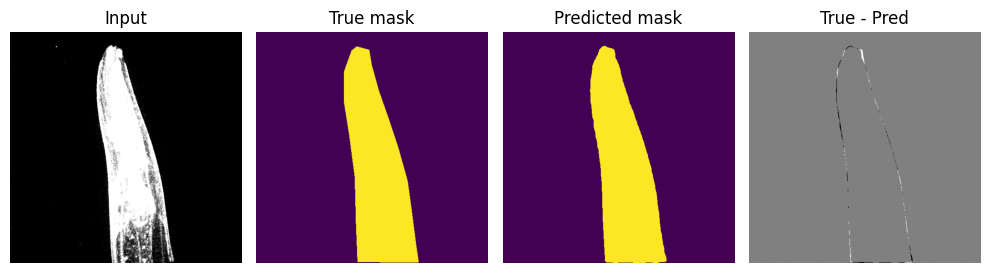

In [22]:
# -----------------------------
# Quick visualization 
# -----------------------------
# pick a random image from the whole set
i = np.random.randint(0, len(image_paths))
print('Random example index:', i)

with torch.no_grad():
    model.eval()
    img_np = image_to_3ch_zscore(image_paths[i])  # (H, W, 3)
    img_t = torch.from_numpy(img_np).permute(2, 0, 1).unsqueeze(0).to(DEVICE)
    logits = model(img_t)               # (1, 2, H, W)
    pred = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()
true_label = label_to_class_indices(label_paths[i])

plt.figure(figsize=(10, 4))
plt.subplot(1, 4, 1)
plt.title('Input')
plt.imshow(img_np, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title('True mask')
plt.imshow(true_label, cmap='viridis')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title('Predicted mask')
plt.imshow(pred, cmap='viridis')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title('True - Pred')
plt.imshow(true_label-pred, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()